# Project Proposal - Predicting the Likelihood of Heart Conditions based on _________ 

#### Lisa Li, Jovan Kannitho, Justin An, Tammy Ou

## Introduction

Heart conditions can be determiend by a variaety of factors, which include an individual's inherant characteristics, such as age and sex, as well as lifestyle choises, such ask smoking and amount of exercise. The objective of the project is to determine the presence of heart condition based on a person's biological factors. We will analyze Heart Disease Data Set which consists of fourteen variables to measure the 
the health conditions of individuals in VA Long Beach. Ultimately, our goal is to address: **Does an individual likely to develop heart disease based on their ____ _____ and _____?**

## Preliminary data exploration analysis

In [1]:
# install.packages("psych")
# install.packages("ggcorrplot")
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
library(kknn)
library(psych)
library(ggcorrplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading and Cleaning Data

In [39]:
#reading data and changing names of the columns
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"
column_names <- c("age",
                  "sex",
                  "chest_pain",
                  "resting_bp",
                  "cholestrol", 
                  "fasting_bp",
                  "resting_ecg",
                  "max_hrate_achieved",
                  "exercise_induced_angina",
                  "st_depression",
                  "slope",
                  "major_vessels",
                  "thalassemia", # too much iron in blood
                  "num")


va_heart_data <- read_csv(url,
                    col_names = c(column_names),
                    col_types = list("d", "f", "f", "d", "d", "f", "f", "d", "f", "d", "f", "i", "f", "d")) 

# changed diagnosis levels of 0-4 to True and False
# if True -> presence of heart disease, False -> absence of heart disease
va_heart_data_clean <- va_heart_data |>
    mutate(diagnosis = num > 0) 

#looking at distribution of sex (0 = female, 1 = male)
count_sex <- va_heart_data |>
   group_by(sex) |>
   summarize(count = n()) 
    
                                  
#changing all unknown values (?) to NA values
va_heart_data_clean[va_heart_data_clean == "?"] <- NA 
va_heart_data_clean

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


age,sex,chest_pain,resting_bp,cholestrol,fasting_bp,resting_ecg,max_hrate_achieved,exercise_induced_angina,st_depression,slope,major_vessels,thalassemia,num,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<dbl>,<lgl>
63,1,4,140,260,0,1,112,1,3.0,2,NA,NA,2,TRUE
44,1,4,130,209,0,1,127,0,0.0,NA,NA,NA,0,FALSE
60,1,4,132,218,0,1,140,1,1.5,3,NA,NA,2,TRUE
55,1,4,142,228,0,1,149,1,2.5,1,NA,NA,1,TRUE
66,1,3,110,213,1,2,99,1,1.3,2,NA,NA,0,FALSE
66,1,3,120,0,0,1,120,0,-0.5,1,NA,NA,0,FALSE
65,1,4,150,236,1,1,105,1,0.0,NA,NA,NA,3,TRUE
60,1,3,180,0,0,1,140,1,1.5,2,NA,NA,0,FALSE
60,1,3,120,0,NA,0,141,1,2.0,1,NA,NA,3,TRUE


We have successfully cleaned and tidied our data as it fits the follwoing 3 requirements: 

1. each row is a single observation
2. each column is a single variable
3. each value is a single cell 

### Summary of Data

By using 75% of our data for training and 25% of our data for testing will enable us to develop a more accurate model to for predictions. A seed was used to ensure that the random distrubution is reproducable. 

In [3]:
set.seed(1)
va_split <- initial_split(va_heart_data_clean, prop = .75, strata = diagnosis)
va_train <- training(va_split)
va_test <- testing(va_split)

va_train

age,sex,chest_pain,resting_bp,cholestrol,fasting_bp,resting_ecg,max_hrate_achieved,exercise_induced_angina,st_depression,slope,major_vessels,thalassemia,num,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<dbl>,<lgl>
44,1,4,130,209,0,1,127,0,0.0,NA,NA,NA,0,FALSE
66,1,3,120,0,0,1,120,0,-0.5,1,NA,NA,0,FALSE
60,1,3,180,0,0,1,140,1,1.5,2,NA,NA,0,FALSE
62,1,4,120,220,0,1,86,0,0.0,NA,NA,NA,0,FALSE
63,1,4,126,0,0,1,120,0,1.5,3,NA,NA,0,FALSE
60,1,4,152,0,0,1,118,1,0.0,NA,NA,7,0,FALSE
74,1,3,NA,0,0,0,NA,NA,NA,NA,NA,NA,0,FALSE
60,1,4,120,0,0,0,133,1,2.0,1,NA,7,0,FALSE
41,1,4,104,0,0,1,111,0,0.0,NA,NA,NA,0,FALSE


In [24]:
# va_train |>
# summarize(across(age:diagnosis, mean, na.rm = TRUE))

na_count <- colSums(is.na(va_train))

na_count

#from this na count, we can see that major vessels and thalassemia columns have a lot of missing values, so we will not use these variables as predictors

va_train_select <- va_train |>
                   select(-thalassemia,-major_vessels)


age                     sex              chest_pain 
                      0                       0                       0 
             resting_bp              cholestrol              fasting_bp 
                     47                       3                       5 
            resting_ecg      max_hrate_achieved exercise_induced_angina 
                      0                      45                      45 
          st_depression                   slope           major_vessels 
                     47                      79                     148 
            thalassemia                     num               diagnosis 
                    121                       0                       0

In [30]:
#split our va_train_select into two dataframes: one with our numeric (num) variables, and one with our categorical (cat) variables

va_train_select_num <- va_train_select |>
                        select(diagnosis, age, resting_bp, cholestrol, max_hrate_achieved, st_depression, diagnosis)

va_train_select_cat <- va_train_select |>
                        select(sex, chest_pain, fasting_bp, resting_ecg, exercise_induced_angina, slope, diagnosis)

A correlation matrix of our training data will allow us to find the variables with the highest impact on heart disease. Using the numeric variables helps us determine the best variables to explore using the knn algorithm. 

In [46]:
#omiting all NA variables in the dataset
va_train_select_num_noNA  <- va_train_select_num |>
  mutate(across(everything(), ~ifelse(. == "?", NA, .))) |>
  na.omit()

va_train_select_num_noNA 



va_train_select_noNA  <- va_train_select |>
  mutate(across(everything(), ~ifelse(. == "?", NA, .))) |>
  na.omit()

va_train_select_noNA

diagnosis,age,resting_bp,cholestrol,max_hrate_achieved,st_depression
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,44,130,209,127,0.0
FALSE,66,120,0,120,-0.5
FALSE,60,180,0,140,1.5
FALSE,62,120,220,86,0.0
FALSE,63,126,0,120,1.5
FALSE,60,152,0,118,0.0
FALSE,60,120,0,133,2.0
FALSE,41,104,0,111,0.0
FALSE,42,134,240,160,0.0


age,sex,chest_pain,resting_bp,cholestrol,fasting_bp,resting_ecg,max_hrate_achieved,exercise_induced_angina,st_depression,slope,num,diagnosis
<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<lgl>
66,1,2,120,0,1,1,120,2,-0.5,4,0,FALSE
60,1,2,180,0,1,1,140,1,1.5,1,0,FALSE
63,1,1,126,0,1,1,120,2,1.5,3,0,FALSE
60,1,1,120,0,1,3,133,1,2.0,4,0,FALSE
58,1,1,132,458,2,3,69,2,1.0,3,0,FALSE
63,1,2,130,0,2,1,160,2,3.0,1,0,FALSE
64,1,1,130,223,1,1,128,2,0.5,1,0,FALSE
75,1,1,160,310,2,3,112,1,2.0,3,0,FALSE
59,1,1,140,274,1,3,154,1,2.0,1,0,FALSE


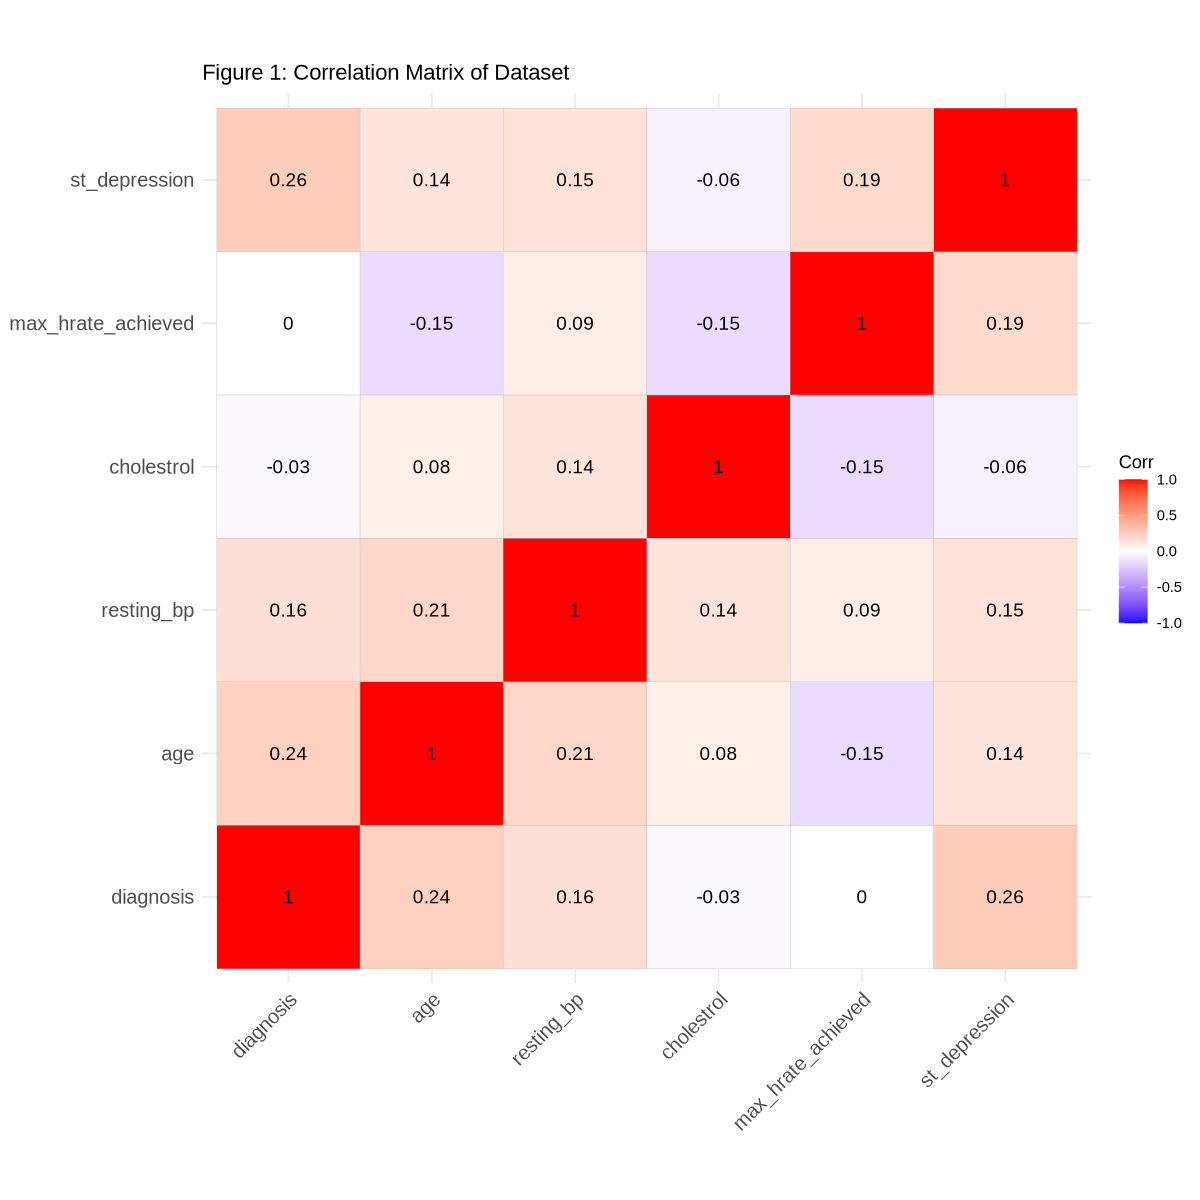

In [48]:
#making a correlation matrix of data using cor()
options(repr.plot.width = 10, repr.plot.height = 10)
correlation_matrix <- cor(va_train_select_num_noNA)

#creating a plot of the results 
ggcorrplot(correlation_matrix, lab = TRUE) + 
    labs(title = "Figure 1: Correlation Matrix of Dataset")


While the variables do not have a significant correlation with diagnosis, the correlation matrix determines st depression, age and resting blood pressure to have the highest impact on determining the presence of heart disease. Thus we will expore these variable further by summarizing their data. 

In [54]:
#selecting the 3 vairables with the highest correlation to heart disease as determined by correlation matrix
#renamed columns to increase clarity
va_heart_data_top_3 <-select(va_train_select_num_noNA, "st_depression","age", "resting_bp")
  

col_names = c("ST Depression", "Age", "Resting Blood Pressure")


#creating a table which summarizes the values of the variables
va_heart_data_top_3_summary <- as.data.frame(apply(va_heart_data_top_3, 2, summary))
va_heart_data_top_3_summary



ERROR: Error in col_names: The pipe operator requires a function call as RHS (<text>:4:5)


In [36]:
#calculate the means for all our numeric predictors

means <- va_train_select_num |>
         map_df(mean, na.rm = TRUE)

means

diagnosis,age,resting_bp,cholestrol,max_hrate_achieved,st_depression
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7449664,59.4094,135.8529,177.4315,122.25,1.316667


In [19]:
#do a count for all our categorical variables

count_sex <- va_train_select_cat |>
   group_by(sex) |>
   summarize(count=n()) 

count_sex   # from this count, we can see that basically most of the dataset is of males. 
            # Thus, we should change our analysis scope to only predicitng heart disease for MALES

count_cp <- va_train_select_cat |>
   group_by(chest_pain) |>
   summarize(count=n()) 

count_cp

count_fasting_bp <- va_train_select_cat |>
   group_by(fasting_bp) |>
   summarize(count=n()) 

count_fasting_bp

count_r.ecg <- va_train_select_cat |>
   group_by(resting_ecg) |>
   summarize(count=n()) 

count_r.ecg






sex,count
<fct>,<int>
1,143
0,6


chest_pain,count
<fct>,<int>
4,97
3,36
2,8
1,8


fasting_bp,count
<fct>,<int>
0,93
1,51
NA,5


resting_ecg,count
<fct>,<int>
1,69
2,21
0,59
